# In this notebook, we implement Overlap-Save Block FFT Convolution Filtering
## Block FFT based processing is important, since it allows us to implement digital filters in "real time" (i.e. in a plugin for a DAW or max/MSP)
## We also use our truncated IIR filter example from the previous notebook, showing that its possible to implment IIR filters using FFT based block convolution, something that is not widely appreciated. 
### FFT based block convolution algorithms are a perfect match for the numerical processing on GPU's and SIMD vector units in modern CPU's 

In [32]:
include("simplot.jl")
using PyPlot
using DSP 
using FFTW 
using WAV 
display("text/html", "<style>.container { width:100% !important; }</style>")

In [33]:
function cp10hH(centerHz,octave3dB,gaindB,f_samp,P)
    
    f_nyq = f_samp / 2;
    T = 1 ./ f_samp;

    if gaindB >= 0
        boostcutflag = 1
    else
        boostcutflag = 0
    end
    
    gaindB = abs(gaindB) 

    ## % Pf is prewarped frequency (from Matlab "doc bilinear")
    f_p = centerHz;
    Pf = (2 .* pi .* f_p) / ( tan(pi .* (f_p / f_samp)));
    G = 10^(gaindB / 20);
    Q = 1.43 / octave3dB;

    W = 2 * pi * centerHz;

    bzmath = zeros(3,1)
    azmath = zeros(3,1) 

    if boostcutflag == 0
        ## CUT equation
        ## from Mathematica 
        bzmath[1] = Pf.^2 .* Q .+ Pf .* W .+ Q .* W.^2;
        bzmath[2] = -2 .* Pf.^2 .* Q .+ 2 .* Q .* W.^2;
        bzmath[3] = Pf.^2 .*Q .- Pf .* W .+ Q .* W.^2;

        azmath[1] = Pf.^2 .* Q .+ G .* Pf .* W + Q .* W.^2;
        azmath[2] =  -2 .* Pf.^2 .* Q .+ 2 .* Q .* W.^2;
        azmath[3] =  Pf.^2 .*Q - G .* Pf .* W .+ Q .* W.^2;

        bzmath = bzmath ./ azmath[1];
        azmath = azmath ./ azmath[1];
    end

    
    if boostcutflag == 1 
    
        ## BOOST equation 
        bzmath[1] = Pf.^2 .* Q .+ G .* Pf .* W .+ Q .* W.^2;
        bzmath[2] = -2 .* Pf.^2 .* Q .+ 2 .* Q .* W.^2;
        bzmath[3] = Pf.^2 .* Q .- G .* Pf .* W .+ Q .* W.^2;
  
        azmath[1] = Pf.^2 .* Q .+ Pf .* W .+ Q .* W.^2;
        azmath[2] = -2 .* Pf.^2 .* Q .+ 2 .* Q .* W.^2;
        azmath[3] = Pf.^2 .* Q .- Pf .* W .+ Q .* W.^2;

        bzmath = bzmath ./ azmath[1];
        azmath = azmath ./ azmath[1];

    end


    b0 = bzmath[1]
    b1 = bzmath[2]
    b2 = bzmath[3]

    a0 = azmath[1];
    a1 = azmath[2];
    a2 = azmath[3];

    b = bzmath;
    a = azmath;

    ## calculationg H(e^{j w}) (Fourier transform) 
    n = 0:(P-1);
    n2 = 0:(P/2);
    f2 = (f_samp .* n2) ./ P
    H2 = zeros(div(P,2) + 1,1)

    z = exp.(im .* 2 .* pi .* (n ./ P));
    Htop  = b0 .+ b1 .* z.^(-1) .+ b2 .* z.^(-2);
    Hbot = 1 .+ a1 .* z.^(-1) .+ a2 .* z.^(-2);
    H = Htop ./ Hbot;

    H2 = H[1:div(P,2)+1]

    B = b2/a2;
    c1 = b1 - ((b2/a2)*a1);
    c0 = b0 - (b2/a2);

    alpha = (-a1 + sqrt(complex(a1^2 - 4 * a2)))/2;
    beta = (-a1 - sqrt(complex(a1^2 - 4 * a2)))/2;

    A1 = ((c1 / alpha) + c0) / ( 1 - (beta / alpha));
    
    A2 = ( (c1 / beta) + c0) / ( 1 - (alpha / beta));

    h = zeros(P,1)


    h[n[1]+1] = B .+ A1 .+ A2;
    h[ n[2:end] .+ 1,1] = A1 .* alpha.^( n[2:end]) .+ A2 .* beta.^(n[2:end]);

    ## note equivalence of h versus hifft f
    ##maximum(  abs.(h - real(ifft(H)) ))

    return f2,H2,b,a,h,H
    
end



cp10hH (generic function with 1 method)

In [34]:
f2,H2,b,a,h,H= cp10hH(2000,0.5,-28,48e3,2^12);

In [35]:
f_samp = 48e3
dt = 1 / f_samp
N = 50000
n = collect(0:(N-1))
x1 = sin.(2 * pi * 100 * n ./ f_samp)
x2 = sin.(2 * pi * 2000 * n ./ f_samp)
x = x1 + x2;


In [36]:
wavplay(x,f_samp)

In [37]:
y = filt(vec(b),vec(a),x);

In [38]:
wavplay(y,f_samp)

In [39]:
h[200]

7.094568529887783e-5

In [40]:
h[400]

1.6295586327378027e-7

In [41]:
h[1024]

9.524436294230895e-16

In [42]:
htrunc = h[1:1024];

In [43]:
a = zeros(length(htrunc))
a[1] = 1.0

ytrunc = filt(vec(htrunc),a,x);

In [44]:
length(y)

50000

In [45]:
length(ytrunc)

50000

# ALL useful IIR filters (i.e. stable...) have impulse response h that decays to zero
# so ALL IIR filters can be converted to FIR filters
# AND THIS MEANS we CAN USE FFT based convolution to implement ANY LTI filter we can dream up!!!!
## But we have Julia, so lets check out if this crazy talk is actually true!

<img src="FFTpseudo.png">

In [46]:
function naive_convolution(h,x)

    L = length(x)
    P = length(h)

    y = zeros(L+P-1)
    xp = zeros(L+P-1)
    hp = zeros(L+P-1)
    
    xp[1:L] = x
    xp[L+1:L+P-1] .= 0

    hp[1:P] = h
    hp[P+1:L+P-1] .= 0

    X = fft(xp)
    H = fft(hp)
    Y = X .* H
    y = ifft(Y)

    return(real(y))
    

end


naive_convolution (generic function with 1 method)

In [47]:
yfft = naive_convolution(vec(htrunc),x);

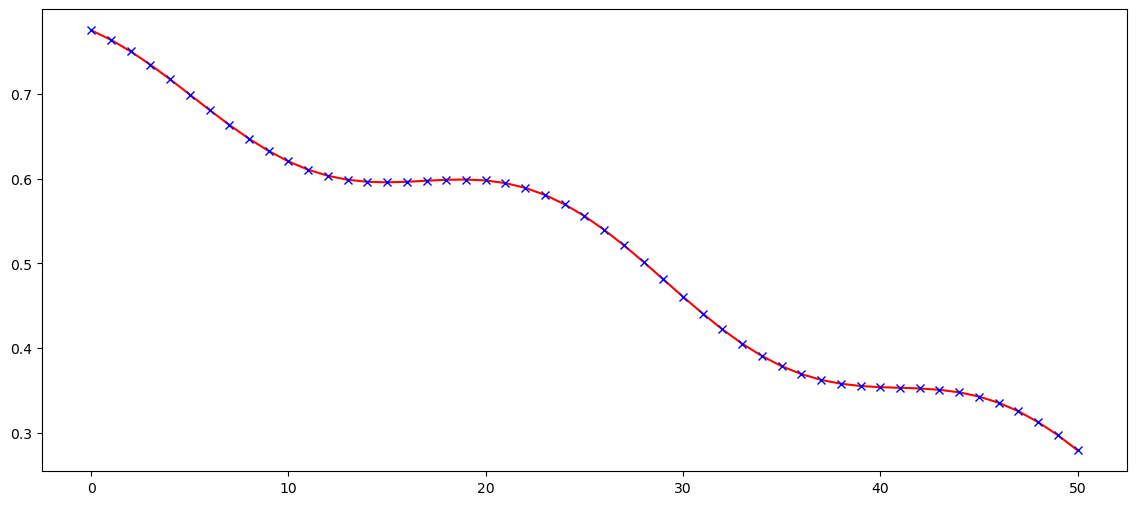

In [48]:
## a sanity check -- our naive convolution algorithm matches the build in Julia filter algorithm. Same as previous notebook. 

fig = figure("Title of Window",figsize=(14,6))
plot(y[200:250],"-r")
plot(yfft[200:250],"xb");

# IIR filters and FIR filters are the same, numerically. This is more important than you might realize.  

# I'm sure some of you have thought of a gotcha.  This only works "offline", not in "real time" like "real" "analog" IIR filters...

# OVERLAP-SAVE FFT Based Block Convolution!  
### The notes below are taking directly from the "industry standard textbook) "Discrete Time Signal Processing" by Oppenheim and Schafer

<img src="os1.png">

<img src="os2.png">

<img src="os3.png">

# Real-Time LTI Filtering (FIR and IIR) with FFT based Block Convolution.  Welcome to the 21st Century!!! 

# And there are no audio artifacts from a well done block convolution code. Just like Direct Form IIR is numerically equivalent to FFT Conolution...

In [49]:
# Julia Overlap-save algorithm setup 
y_OVS = zeros(N) 
P = length(htrunc)
# our "chunk length" for block convolution is 256
L = P + 256
chunklength = L - P + 1
chunk = zeros(chunklength)

xr = zeros(L) 

yrp = zeros(L+P-1)
yr = zeros(L+P-1)
R = Int(floor(N / chunklength)) - 2 

192

## This is the main overlap save block convolution algorithm. 
#### Its conceptually simple, but the bookeeping is tricky 
#### (This is a very naive Julia algorithm, there are many ways to improve the numerical speed)

In [50]:
# this is the Block (chunk) FFT based convolution algorithm. 
# for every r, it takes a chunk of input samples, uses zero-padding FFT for the processing
# (the same naive fft convolution function from before, but now on smaller blocks or chunks)
for r=4:R
    # pick out a "chunk from the input stream x[n]"
    for n=1:(L)
        xr[n] = x[n + r * (L - P + 1) - P + 1]
    end
    # do the FFT (block/chunk) convolution
    global yrp = naive_convolution(xr,htrunc)
    # pick out the valid samples 
    for n=(P):(L)
        global yr[n] = yrp[n]
    end
    global chunk = yr[P:L]
    LL = length(chunk)
    # add the valid samples to the output (filtered) stream y_OVS[]
    global y_OVS[1 + ((r-1) * LL):LL + ((r-1) * LL)] = chunk
end



In [51]:
# our naive block convolution algorithm does not handle startup yet, so pick out valid "middle" 
y_OVS_trunc = y_OVS[772:end-1000]

# pick out the correspoding values from our earlier yfft convolution 
yfft_trunc = yfft[1029:1029 + (length(y_OVS_trunc) -1)]

# compare

maximum(y_OVS_trunc - yfft_trunc)




1.6653345369377348e-15

## this result (1.6e-15) means that our block convolution algorithm is numerically identical to  single FFT convolution algorithm (as well as the direct filter algorithm)
## this means its "perfect", there are no audible artifacts for doing the processing in blocks. 
### we can intuitively prove this by listening to both the block convolution filter, and the single convolution filter.  They both sound the same, and 
### there are no audible artifacts from the block processing. 

In [52]:
wavplay(y_OVS_trunc,f_samp)

In [53]:
wavplay(yfft_trunc,f_samp)